# FAKE NEWS CLASSIFIER

In [4]:
#importing libraries
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import re
pd.set_option('max_colwidth', 800)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [1]:
# downloading glove files in web browser
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2021-09-01 06:06:36--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-09-01 06:06:37--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-09-01 06:06:37--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [2]:
# unzipping the zip files
!unzip glove.6B.zip


Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [5]:
!pip install keras_metrics

In [6]:
# importing deep learning libraries
import tqdm
import keras_metrics # for recall and precision metrics
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import time
import pickle

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#learning word embeddings on training data using Gensim library
from gensim.models import Word2Vec, KeyedVectors
# gensim modules
from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec

In [8]:
#loading dataset
d1=pd.read_csv('/content/drive/MyDrive/Fake.csv')
d1.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing,"Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year, President Angry Pants tweeted. 2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America! Donald J. Trump (@realDonaldTrump) December 3...",News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian Collusion Investigation,"House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump. As it happens, the dossier is not what started the investigation, according to documents obtained by the New York Times.Former Trump campaign adviser George Papadopoulos was drunk in a wine bar when he revealed knowledge of Russian opposition research on Hillary Clinton.On top of that, Papadopoulos wasn t just a covfefe boy for Trump, as his administration has alleged. He had a much larger role, but none so damning as being a drunken fool in a wine bar. Coffee boys don t help to arrange a Ne...",News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’,"On Friday, it was revealed that former Milwaukee Sheriff David Clarke, who was being considered for Homeland Security Secretary in Donald Trump s administration, has an email scandal of his own.In January, there was a brief run-in on a plane between Clarke and fellow passenger Dan Black, who he later had detained by the police for no reason whatsoever, except that maybe his feelings were hurt. Clarke messaged the police to stop Black after he deplaned, and now, a search warrant has been executed by the FBI to see the exchanges.Clarke is calling it fake news even though copies of the search warrant are on the Internet. I am UNINTIMIDATED by lib media attempts to smear and discredit me with their FAKE NEWS reports designed to silence me, the former sheriff tweeted. I will continue to p...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name Coded Into His Website (IMAGES),"On Christmas day, Donald Trump announced that he would be back to work the following day, but he is golfing for the fourth day in a row. The former reality show star blasted former President Barack Obama for playing golf and now Trump is on track to outpace the number of golf games his predecessor played.Updated my tracker of Trump s appearances at Trump properties.71 rounds of golf including today s. At this pace, he ll pass Obama s first-term total by July 24 next year. https://t.co/Fg7VacxRtJ pic.twitter.com/5gEMcjQTbH Philip Bump (@pbump) December 29, 2017 That makes what a Washington Post reporter discovered on Trump s website really weird, but everything about this administration is bizarre AF. The coding contained a reference to Obama and golf: Unlike Obama, we are working t...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump During His Christmas Speech,"Pope Francis used his annual Christmas Day message to rebuke Donald Trump without even mentioning his name. The Pope delivered his message just days after members of the United Nations condemned Trump s move to recognize Jerusalem as the capital of Israel. The Pontiff prayed on Mon

In [9]:
d2=pd.read_csv('/content/drive/MyDrive/True.csv')
d2.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip their fiscal script","WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President ...",politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits on Monday: Pentagon,"WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trump’s administration decided not to appeal rulings that blocked his transgender ban. Two federal appeals courts, one in Washington and one in Virginia, last week rejected the administration’s request to put on hold orders by lower court judges requiring the military to begin accepting transgender recruits on Jan. 1. A Justice Department official said the administration will not challenge those rulings. “The Department of Defense has announced that it will be releasing an independent study of these issues in the coming weeks. So rather than litigate this interim appeal before tha...",politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Mueller do his job',"WASHINGTON (Reuters) - The special counsel investigation of links between Russia and President Trump’s 2016 election campaign should continue without interference in 2018, despite calls from some Trump administration allies and Republican lawmakers to shut it down, a prominent Republican senator said on Sunday. Lindsey Graham, who serves on the Senate armed forces and judiciary committees, said Department of Justice Special Counsel Robert Mueller needs to carry on with his Russia investigation without political interference. “This investigation will go forward. It will be an investigation conducted without political influence,” Graham said on CBS’s Face the Nation news program. “And we all need to let Mr. Mueller do his job. I think he’s the right guy at the right time.” The question ...",politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat tip-off: NYT,"WASHINGTON (Reuters) - Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had political dirt on Democratic presidential candidate Hillary Clinton, the New York Times reported on Saturday. The conversation between Papadopoulos and the diplomat, Alexander Downer, in London was a driving factor behind the FBI’s decision to open a counter-intelligence investigation of Moscow’s contacts with the Trump campaign, the Times reported. Two months after the meeting, Australian officials passed the information that came from Papadopoulos to their American counterparts when leaked Democratic emails began appearing online, according to the newspaper, which cited four current and former U.S. and foreign officials. Besides the information from the Australian...",politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much more' for Amazon shipments,"SEATTLE/WASHINGTON (Reuters) - President Donald Trump called on the U.S. Postal Service on Friday to charge “much more” to ship packages for Amazon (AMZN.O), picking another fight with an online retail giant he has criticized in the past. “Why is the United States Post Office, which is losing many bil

In [10]:
d1['label'] = 0 # fake news
d2['label'] = 1 # true news

## DATA CLEANING AND EDA

### DATASET I - DATA CLEANING

In [11]:
d1.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing,"Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year, President Angry Pants tweeted. 2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America! Donald J. Trump (@realDonaldTrump) December 3...",News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian Collusion Investigation,"House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump. As it happens, the dossier is not what started the investigation, according to documents obtained by the New York Times.Former Trump campaign adviser George Papadopoulos was drunk in a wine bar when he revealed knowledge of Russian opposition research on Hillary Clinton.On top of that, Papadopoulos wasn t just a covfefe boy for Trump, as his administration has alleged. He had a much larger role, but none so damning as being a drunken fool in a wine bar. Coffee boys don t help to arrange a Ne...",News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’,"On Friday, it was revealed that former Milwaukee Sheriff David Clarke, who was being considered for Homeland Security Secretary in Donald Trump s administration, has an email scandal of his own.In January, there was a brief run-in on a plane between Clarke and fellow passenger Dan Black, who he later had detained by the police for no reason whatsoever, except that maybe his feelings were hurt. Clarke messaged the police to stop Black after he deplaned, and now, a search warrant has been executed by the FBI to see the exchanges.Clarke is calling it fake news even though copies of the search warrant are on the Internet. I am UNINTIMIDATED by lib media attempts to smear and discredit me with their FAKE NEWS reports designed to silence me, the former sheriff tweeted. I will continue to p...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name Coded Into His Website (IMAGES),"On Christmas day, Donald Trump announced that he would be back to work the following day, but he is golfing for the fourth day in a row. The former reality show star blasted former President Barack Obama for playing golf and now Trump is on track to outpace the number of golf games his predecessor played.Updated my tracker of Trump s appearances at Trump properties.71 rounds of golf including today s. At this pace, he ll pass Obama s first-term total by July 24 next year. https://t.co/Fg7VacxRtJ pic.twitter.com/5gEMcjQTbH Philip Bump (@pbump) December 29, 2017 That makes what a Washington Post reporter discovered on Trump s website really weird, but everything about this administration is bizarre AF. The coding contained a reference to Obama and golf: Unlike Obama, we are working t...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump During His Christmas Speech,"Pope Francis used his annual Christmas Day message to rebuke Donald Trump without even mentioning his name. The Pope delivered his message just days after members of the United Nations condemned Trump s move to recognize Jerusalem as the capital of Israel. The Pontiff

Noticed some words in fake dataset that are present in the true dataset. 
[BOILER ROOM:, WARNING:, FLASHBACK:, VIDEO:, WATCH!, BREAKING:, WATCH:, REPORT:, WATCH AND LAUGH:, BREAKING NEWS:, UPDATED VIDEO:, UPDATE:, SHOCKING:, POLL:, Factbox:]. These words are present in the start. 
e.g WATCH: Paul Ryan Just Told Us. 
So these words do not use for prediction (whether the news is fake or not). So making this with the empty string.

In [12]:
d1['title'] = d1['title'].str.replace('BOILER ROOM:', '')
d1['title'] = d1['title'].str.replace('WARNING:', '')
d1['title'] = d1['title'].str.replace('FLASHBACK:', '')
d1['title'] = d1['title'].str.replace('VIDEO:', '')
d1['title'] = d1['title'].str.replace('BREAKING:', '')
d1['title'] = d1['title'].str.replace('BREAKING NEWS:', '')
d1['title'] = d1['title'].str.replace('WATCH:', '')
d1['title'] = d1['title'].str.replace('REPORT: ', '')
d1['title'] = d1['title'].str.replace('WATCH AND LAUGH:', '')
d1['title'] = d1['title'].str.replace('UPDATE:', '')
d1['title'] = d1['title'].str.replace('SHOCKING:', '')
d1['title'] = d1['title'].str.replace('POLL:', '')
d1['title'] = d1['title'].str.replace('WATCH!', '')
d1['title'] = d1['title'].str.replace('UPDATED VIDEO:', '')
d1['title'] = d1['title'].str.replace('Factbox:', '')

### DATASET II - DATA CLEANING

In [13]:
# 'factbox:'. so removing them
d2['title'] = d2['title'].str.replace('Factbox:', '')

Difference in Text

Real news seems to have source of publication which is not present in fake news set

Looking at the data:

1. most of text contains reuters information such as "WASHINGTON (Reuters)".
2. Some text are tweets from Twitter.
3. Few text do not contain any publication info.



In [14]:
#First Creating list of index that do not have publication part
unknown_publishers = []
for index,row in enumerate(d2.text.values):
    try:
        record = row.split(" -", maxsplit=1)
        #if no text part is present, following will give error
        record[1]
        #if len of piblication part is greater than 260
        #following will give error, ensuring no text having "-" in between is counted
        assert(len(record[0]) < 260)
    except:
        unknown_publishers.append(index)

In [15]:
#Thus we have list of indices where publisher is not mentioned
#lets check
d2.iloc[unknown_publishers].text
#true, they do not have text like "WASHINGTON (Reuters)"

3488     The White House on Wednesday disclosed a group of former lobbyists working in President Donald Trump’s administration who have been issued ethics waivers, following a request from the U.S. government’s ethics agency. The list of at least 11 waivers include White House adviser Kellyanne Conway and Trump's Chief of Staff Reince Priebus, according to a chart issued on the White House website. (bit.ly/1LPKWx8) Conway is permitted to “participate in communications and meetings involving former clients which are political, advocacy, trade or non-profit organizations,” while Priebus, a former Republican National Committee chairman, is allowed to have communications and meetings with the RNC, the document says. Shortly after taking office in January, Trump signed an executive order barring lob...
4358     Neil Gorsuch, President Donald Trump’s appointee to the U.S. Supreme Court who was confirmed by the Senate to the lifetime job on Friday in a 54-45 vote, will have an immediate impac

In [16]:
#Seperating Publication info, from actual text
publisher = []
tmp_text = []
for index,row in enumerate(d2.text.values):
    if index in unknown_publishers:
        #Add unknown of publisher not mentioned
        tmp_text.append(row)
        
        publisher.append("Unknown")
        continue
    record = row.split(" -", maxsplit=1)
    publisher.append(record[0])
    tmp_text.append(record[1])

In [17]:
#Replace existing text column with new text
#add seperate column for publication info
d2["publisher"] = publisher
d2["text"] = tmp_text

del publisher, tmp_text, record, unknown_publishers

In [18]:
d2.head()

,title,text,subject,date,label,publisher
0,"As U.S. budget fight looms, Republicans flip their fiscal script","The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his R...",politicsNews,"December 31, 2017",1,WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits on Monday: Pentagon,"Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trump’s administration decided not to appeal rulings that blocked his transgender ban. Two federal appeals courts, one in Washington and one in Virginia, last week rejected the administration’s request to put on hold orders by lower court judges requiring the military to begin accepting transgender recruits on Jan. 1. A Justice Department official said the administration will not challenge those rulings. “The Department of Defense has announced that it will be releasing an independent study of these issues in the coming weeks. So rather than litigate this interim appeal before that occurs, the administ...",politicsNews,"December 29, 2017",1,WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Mueller do his job',"The special counsel investigation of links between Russia and President Trump’s 2016 election campaign should continue without interference in 2018, despite calls from some Trump administration allies and Republican lawmakers to shut it down, a prominent Republican senator said on Sunday. Lindsey Graham, who serves on the Senate armed forces and judiciary committees, said Department of Justice Special Counsel Robert Mueller needs to carry on with his Russia investigation without political interference. “This investigation will go forward. It will be an investigation conducted without political influence,” Graham said on CBS’s Face the Nation news program. “And we all need to let Mr. Mueller do his job. I think he’s the right guy at the right time.” The question of how Russia may have...",politicsNews,"December 31, 2017",1,WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat tip-off: NYT,"Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had political dirt on Democratic presidential candidate Hillary Clinton, the New York Times reported on Saturday. The conversation between Papadopoulos and the diplomat, Alexander Downer, in London was a driving factor behind the FBI’s decision to open a counter-intelligence investigation of Moscow’s contacts with the Trump campaign, the Times reported. Two months after the meeting, Australian officials passed the information that came from Papadopoulos to their American counterparts when leaked Democratic emails began appearing online, according to the newspaper, which cited four current and former U.S. and foreign officials. Besides the information from the Australians, the probe by the Fe...",politicsNews,"December 30, 2017",1,WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much more' for Amazon shipments,"President Donald Trump called on the U.S. Postal Service on Friday to charge “much more” to ship packages for Amazon (AMZN.O), picking another fight with an online retail giant he has criticized in 

In [19]:
d2['publisher'].value_counts()

WASHINGTON (Reuters)                        6389
(Reuters)                                   1483
LONDON (Reuters)                             705
NEW YORK (Reuters)                           695
MOSCOW (Reuters)                             623
                                            ... 
NEW YORK/ANKARA (Reuters)                      1
 NOGALES, Arizona (Reuters)                    1
MYEBON, Myanmar (Reuters)                      1
SACRAMENTO, Calif./LOS ANGELES (Reuters)       1
SANDY SPRINGS, Ga. (Reuters)                   1
Name: publisher, Length: 1692, dtype: int64

In [20]:
d2.drop(['publisher'], axis=1, inplace=True)
d2.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip their fiscal script","The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his R...",politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits on Monday: Pentagon,"Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trump’s administration decided not to appeal rulings that blocked his transgender ban. Two federal appeals courts, one in Washington and one in Virginia, last week rejected the administration’s request to put on hold orders by lower court judges requiring the military to begin accepting transgender recruits on Jan. 1. A Justice Department official said the administration will not challenge those rulings. “The Department of Defense has announced that it will be releasing an independent study of these issues in the coming weeks. So rather than litigate this interim appeal before that occurs, the administ...",politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Mueller do his job',"The special counsel investigation of links between Russia and President Trump’s 2016 election campaign should continue without interference in 2018, despite calls from some Trump administration allies and Republican lawmakers to shut it down, a prominent Republican senator said on Sunday. Lindsey Graham, who serves on the Senate armed forces and judiciary committees, said Department of Justice Special Counsel Robert Mueller needs to carry on with his Russia investigation without political interference. “This investigation will go forward. It will be an investigation conducted without political influence,” Graham said on CBS’s Face the Nation news program. “And we all need to let Mr. Mueller do his job. I think he’s the right guy at the right time.” The question of how Russia may have...",politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat tip-off: NYT,"Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had political dirt on Democratic presidential candidate Hillary Clinton, the New York Times reported on Saturday. The conversation between Papadopoulos and the diplomat, Alexander Downer, in London was a driving factor behind the FBI’s decision to open a counter-intelligence investigation of Moscow’s contacts with the Trump campaign, the Times reported. Two months after the meeting, Australian officials passed the information that came from Papadopoulos to their American counterparts when leaked Democratic emails began appearing online, according to the newspaper, which cited four current and former U.S. and foreign officials. Besides the information from the Australians, the probe by the Fe...",politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much more' for Amazon shipments,"President Donald Trump called on the U.S. Postal Service on Friday to charge “much more” to ship packages for Amazon (AMZN.O), picking another fight with an online retail giant he has criticized in the past. “Why is the United States Post Office, which is losing many billions of dollars a ye

### COMBINING TWO DATASETS

In [21]:
# combining the two datasets or concatenating the two dataset.
frame = [d1, d2]
df = pd.concat(frame)
df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing,"Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year, President Angry Pants tweeted. 2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America! Donald J. Trump (@realDonaldTrump) December 3...",News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian Collusion Investigation,"House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump. As it happens, the dossier is not what started the investigation, according to documents obtained by the New York Times.Former Trump campaign adviser George Papadopoulos was drunk in a wine bar when he revealed knowledge of Russian opposition research on Hillary Clinton.On top of that, Papadopoulos wasn t just a covfefe boy for Trump, as his administration has alleged. He had a much larger role, but none so damning as being a drunken fool in a wine bar. Coffee boys don t help to arrange a Ne...",News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’,"On Friday, it was revealed that former Milwaukee Sheriff David Clarke, who was being considered for Homeland Security Secretary in Donald Trump s administration, has an email scandal of his own.In January, there was a brief run-in on a plane between Clarke and fellow passenger Dan Black, who he later had detained by the police for no reason whatsoever, except that maybe his feelings were hurt. Clarke messaged the police to stop Black after he deplaned, and now, a search warrant has been executed by the FBI to see the exchanges.Clarke is calling it fake news even though copies of the search warrant are on the Internet. I am UNINTIMIDATED by lib media attempts to smear and discredit me with their FAKE NEWS reports designed to silence me, the former sheriff tweeted. I will continue to p...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name Coded Into His Website (IMAGES),"On Christmas day, Donald Trump announced that he would be back to work the following day, but he is golfing for the fourth day in a row. The former reality show star blasted former President Barack Obama for playing golf and now Trump is on track to outpace the number of golf games his predecessor played.Updated my tracker of Trump s appearances at Trump properties.71 rounds of golf including today s. At this pace, he ll pass Obama s first-term total by July 24 next year. https://t.co/Fg7VacxRtJ pic.twitter.com/5gEMcjQTbH Philip Bump (@pbump) December 29, 2017 That makes what a Washington Post reporter discovered on Trump s website really weird, but everything about this administration is bizarre AF. The coding contained a reference to Obama and golf: Unlike Obama, we are working t...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump During His Christmas Speech,"Pope Francis used his annual Christmas Day message to rebuke Donald Trump without even mentioning his name. The Pope delivered his message just days after members of the United Nations condemned Trump s move to recognize Jerusalem as the capital of Israel. The Pontiff

In [22]:
df.shape

(44898, 5)

In [23]:
df.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [24]:
df = df.drop_duplicates()

In [26]:
df.reset_index(inplace=True)

In [27]:
# after dropping duplicates, my new dataset shape. Total duplicates in the entire dataset = 209
df.shape

(44689, 6)

In [28]:
df.columns

Index(['index', 'title', 'text', 'subject', 'date', 'label'], dtype='object')

In [29]:
df['subject'].value_counts()

politicsNews       11220
worldnews           9991
News                9050
politics            6838
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

In [30]:
df['label'].value_counts()

0    23478
1    21211
Name: label, dtype: int64

In [31]:
# dropping unnecessary columns. 
df.drop(['subject', 'date'], axis = 1, inplace=True)
df.head()

,index,title,text,label
0,0,Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing,"Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year, President Angry Pants tweeted. 2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America! Donald J. Trump (@realDonaldTrump) December 3...",0
1,1,Drunk Bragging Trump Staffer Started Russian Collusion Investigation,"House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump. As it happens, the dossier is not what started the investigation, according to documents obtained by the New York Times.Former Trump campaign adviser George Papadopoulos was drunk in a wine bar when he revealed knowledge of Russian opposition research on Hillary Clinton.On top of that, Papadopoulos wasn t just a covfefe boy for Trump, as his administration has alleged. He had a much larger role, but none so damning as being a drunken fool in a wine bar. Coffee boys don t help to arrange a Ne...",0
2,2,Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’,"On Friday, it was revealed that former Milwaukee Sheriff David Clarke, who was being considered for Homeland Security Secretary in Donald Trump s administration, has an email scandal of his own.In January, there was a brief run-in on a plane between Clarke and fellow passenger Dan Black, who he later had detained by the police for no reason whatsoever, except that maybe his feelings were hurt. Clarke messaged the police to stop Black after he deplaned, and now, a search warrant has been executed by the FBI to see the exchanges.Clarke is calling it fake news even though copies of the search warrant are on the Internet. I am UNINTIMIDATED by lib media attempts to smear and discredit me with their FAKE NEWS reports designed to silence me, the former sheriff tweeted. I will continue to p...",0
3,3,Trump Is So Obsessed He Even Has Obama’s Name Coded Into His Website (IMAGES),"On Christmas day, Donald Trump announced that he would be back to work the following day, but he is golfing for the fourth day in a row. The former reality show star blasted former President Barack Obama for playing golf and now Trump is on track to outpace the number of golf games his predecessor played.Updated my tracker of Trump s appearances at Trump properties.71 rounds of golf including today s. At this pace, he ll pass Obama s first-term total by July 24 next year. https://t.co/Fg7VacxRtJ pic.twitter.com/5gEMcjQTbH Philip Bump (@pbump) December 29, 2017 That makes what a Washington Post reporter discovered on Trump s website really weird, but everything about this administration is bizarre AF. The coding contained a reference to Obama and golf: Unlike Obama, we are working t...",0
4,4,Pope Francis Just Called Out Donald Trump During His Christmas Speech,"Pope Francis used his annual Christmas Day message to rebuke Donald Trump without even mentioning his name. The Pope delivered his message just days after members of the United Nations condemned Trump s move to recognize Jerusalem as the capital of Israel. The Pontiff prayed on Monday for the peaceful coexistence of two states within mutually agreed and internati

In [32]:
df.columns

Index(['index', 'title', 'text', 'label'], dtype='object')

In [33]:
df['combine']= df['title'] +' '+ df['text']
df.head()

,index,title,text,label,combine
0,0,Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing,"Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year, President Angry Pants tweeted. 2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America! Donald J. Trump (@realDonaldTrump) December 3...",0,"Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year, President Angry Pants tweeted. 2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 ..."
1,1,Drunk Bragging Trump Staffer Started Russian Collusion Investigation,"House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump. As it happens, the dossier is not what started the investigation, according to documents obtained by the New York Times.Former Trump campaign adviser George Papadopoulos was drunk in a wine bar when he revealed knowledge of Russian opposition research on Hillary Clinton.On top of that, Papadopoulos wasn t just a covfefe boy for Trump, as his administration has alleged. He had a much larger role, but none so damning as being a drunken fool in a wine bar. Coffee boys don t help to arrange a Ne...",0,"Drunk Bragging Trump Staffer Started Russian Collusion Investigation House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump. As it happens, the dossier is not what started the investigation, according to documents obtained by the New York Times.Former Trump campaign adviser George Papadopoulos was drunk in a wine bar when he revealed knowledge of Russian opposition research on Hillary Clinton.On top of that, Papadopoulos wasn t just a covfefe boy for Trump, as his administration has alleged. He had a much larger role, but none so damning as being..."
2,2,Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’,"On Friday, it was revealed that former Milwaukee Sheriff David Clarke, who was being considered for Homeland Security Secretary in Donald Trump s administration, has an email scandal of his own.In January, there was a brief run-in on a plane between Clarke and fellow passenger Dan Black, who he later had detained by the police for no reason whatsoever, except that maybe his feelings were hurt. Clarke messaged the police to stop Black after he deplaned, and now, a search warrant has been executed by the FBI to se

In [34]:
# dropping unnecessary columns. 
df.drop(['index', 'title', 'text'], axis = 1, inplace=True)
df.head()

,label,combine
0,0,"Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year, President Angry Pants tweeted. 2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 ..."
1,0,"Drunk Bragging Trump Staffer Started Russian Collusion Investigation House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump. As it happens, the dossier is not what started the investigation, according to documents obtained by the New York Times.Former Trump campaign adviser George Papadopoulos was drunk in a wine bar when he revealed knowledge of Russian opposition research on Hillary Clinton.On top of that, Papadopoulos wasn t just a covfefe boy for Trump, as his administration has alleged. He had a much larger role, but none so damning as being..."
2,0,"Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’ On Friday, it was revealed that former Milwaukee Sheriff David Clarke, who was being considered for Homeland Security Secretary in Donald Trump s administration, has an email scandal of his own.In January, there was a brief run-in on a plane between Clarke and fellow passenger Dan Black, who he later had detained by the police for no reason whatsoever, except that maybe his feelings were hurt. Clarke messaged the police to stop Black after he deplaned, and now, a search warrant has been executed by the FBI to see the exchanges.Clarke is calling it fake news even though copies of the search warrant are on the Internet. I am UNINTIMIDATED by lib media attempts to smear and discredit me with their F..."
3,0,"Trump Is So Obsessed He Even Has Obama’s Name Coded Into His Website (IMAGES) On Christmas day, Donald Trump announced that he would be back to work the following day, but he is golfing for the fourth day in a row. The former reality show star blasted former President Barack Obama for playing golf and now Trump is on track to outpace the number of golf games his predecessor played.Updated my tracker of Trump s appearances at Trump properties.71 rounds of golf including today s. At this pace, he ll pass Obama s first-term total by July 24 next year. https://t.co/Fg7VacxRtJ pic.twitter.com/5gEMcjQTbH Philip Bump (@pbump) December 29, 2017 That makes what a Washington Post reporter discovered on Trump s website really weird, but everything about this administration is bizarre AF. The ..."
4,0,"Pope Francis Just Called Out Donald Trump During His Christmas Speech Pope Francis used his annual Christmas Day message to rebuke Donald Trump without even mentioning his name. The Pope delivered his message just days after members of the United Nations condemned Trump s move to recognize Jerusalem as the capital of Israel. The Pontiff prayed on Monday for the peaceful coexistence of two states within mutually agreed and internationally recognized borders. We see Jesus in the children of the Middle East who continue to suffer because of growing tensions between Israelis and Palestinians, Francis said. On this festive day, let us ask the Lord for peace for Jerusalem and for all the Holy Land. Let us pray that the will to resume dialogue may prevail between 

In [35]:
# Cleaning Raw tweets
def clean_text(text):
    
    #remove emails
    text = ' '.join([i for i in text.split() if '@' not in i])
    
    #remove web address
    text = re.sub('http[s]?://\S+', '', text)

    #remove brackets and parantheses (and removing the text inside the brackets and parantheses)
    text = re.sub("[\(\[].*?[\)\]]", "", text)

    #remove punctuations
    text = re.sub(r'[^\w\s]', ' ', text)
    
    #Filter to allow only alphabets
    text = re.sub(r'[^a-zA-Z\']', ' ', text)

    #Remove Unicode characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    #remove double spaces 
    text = re.sub('\s+', ' ', text)
    
    return text

In [36]:
# applying that into function.
df["text"] = df['combine'].apply(lambda x: clean_text(x))
df.head(10)

,label,combine,text
0,0,"Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year, President Angry Pants tweeted. 2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 ...",Donald Trump Sends Out Embarrassing New Year s Eve Message This is Disturbing Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that Instead he had to give a shout out to his enemies haters and the very dishonest fake news media The former reality show star had just one job to do and he couldn t do it As our Country rapidly grows stronger and smarter I want to wish all of my friends supporters enemies haters and even the very dishonest Fake News Media a Happy and Healthy New Year President Angry Pants tweeted will be a great year for America As our Country rapidly grows stronger and smarter I want to wish all of my friends supporters enemies haters and even the very dishonest Fake News Media a Happy and Healthy New Year will be a great year for America Dona...
1,0,"Drunk Bragging Trump Staffer Started Russian Collusion Investigation House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump. As it happens, the dossier is not what started the investigation, according to documents obtained by the New York Times.Former Trump campaign adviser George Papadopoulos was drunk in a wine bar when he revealed knowledge of Russian opposition research on Hillary Clinton.On top of that, Papadopoulos wasn t just a covfefe boy for Trump, as his administration has alleged. He had a much larger role, but none so damning as being...",Drunk Bragging Trump Staffer Started Russian Collusion Investigation House Intelligence Committee Chairman Devin Nunes is going to have a bad day He s been under the assumption like many of us that the Christopher Steele dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump As it happens the dossier is not what started the investigation according to documents obtained by the New York Times Former Trump campaign adviser George Papadopoulos was drunk in a wine bar when he revealed knowledge of Russian opposition research on Hillary Clinton On top of that Papadopoulos wasn t just a covfefe boy for Trump as his administration has alleged He had a much larger role but none so damning as being a drunken ...
2,0,"Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’ On Friday, it was revealed that former Milwaukee Sheriff David Clarke, who was being considered for Homeland Security Secretary in Donald Trump s administration, has an email scandal of his own.In January, there was a brief run-in on a plane between Clarke and fellow passenger Dan Black, who he later had detained by the police for no reason whatsoever, except that maybe his feelings were hurt. Clarke messaged the police to stop Black after he deplaned, and now, a search warrant has been executed by the FBI to see the exchanges.Clarke is calling it fake news even though copies of the search warrant are on the Internet. I am UNINTIMIDATED by lib media attempts to smear and

In [37]:
# dropping the uncleaned text column "combine"
df = df.drop(['combine'], axis=1)

In [38]:
df.head()

,label,text
0,0,Donald Trump Sends Out Embarrassing New Year s Eve Message This is Disturbing Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that Instead he had to give a shout out to his enemies haters and the very dishonest fake news media The former reality show star had just one job to do and he couldn t do it As our Country rapidly grows stronger and smarter I want to wish all of my friends supporters enemies haters and even the very dishonest Fake News Media a Happy and Healthy New Year President Angry Pants tweeted will be a great year for America As our Country rapidly grows stronger and smarter I want to wish all of my friends supporters enemies haters and even the very dishonest Fake News Media a Happy and Healthy New Year will be a great year for America Dona...
1,0,Drunk Bragging Trump Staffer Started Russian Collusion Investigation House Intelligence Committee Chairman Devin Nunes is going to have a bad day He s been under the assumption like many of us that the Christopher Steele dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump As it happens the dossier is not what started the investigation according to documents obtained by the New York Times Former Trump campaign adviser George Papadopoulos was drunk in a wine bar when he revealed knowledge of Russian opposition research on Hillary Clinton On top of that Papadopoulos wasn t just a covfefe boy for Trump as his administration has alleged He had a much larger role but none so damning as being a drunken ...
2,0,Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People In The Eye On Friday it was revealed that former Milwaukee Sheriff David Clarke who was being considered for Homeland Security Secretary in Donald Trump s administration has an email scandal of his own In January there was a brief run in on a plane between Clarke and fellow passenger Dan Black who he later had detained by the police for no reason whatsoever except that maybe his feelings were hurt Clarke messaged the police to stop Black after he deplaned and now a search warrant has been executed by the FBI to see the exchanges Clarke is calling it fake news even though copies of the search warrant are on the Internet I am UNINTIMIDATED by lib media attempts to smear and discredit me with their FAKE NEWS repo...
3,0,Trump Is So Obsessed He Even Has Obama s Name Coded Into His Website On Christmas day Donald Trump announced that he would be back to work the following day but he is golfing for the fourth day in a row The former reality show star blasted former President Barack Obama for playing golf and now Trump is on track to outpace the number of golf games his predecessor played Updated my tracker of Trump s appearances at Trump properties rounds of golf including today s At this pace he ll pass Obama s first term total by July next year pic twitter com gEMcjQTbH Philip Bump December That makes what a Washington Post reporter discovered on Trump s website really weird but everything about this administration is bizarre AF The coding contained a reference to Obama and golf Unlike Obama we are wor...
4,0,Pope Francis Just Called Out Donald Trump During His Christmas Speech Pope Francis used his annual Christmas Day message to rebuke Donald Trump without even mentioning his name The Pope delivered his message just days after members of the United Nations condemned Trump s move to recognize Jerusalem as the capital of Israel The Pontiff prayed on Monday for the peaceful coexistence of two states within mutually agreed and internationally recognized borders We see Jesus in the children of the Middle East who continue to suffer because of growing tensions between Israelis and Palestinians Francis said On this festive day let us ask the Lord for peace for Jerusalem and for all the Holy Land Let us pray that the will to resume dialogue may prevail between the part

In [68]:
df['label'].value_counts()

0    23478
1    21211
Name: label, dtype: int64

This is perfectly balanced dataset.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


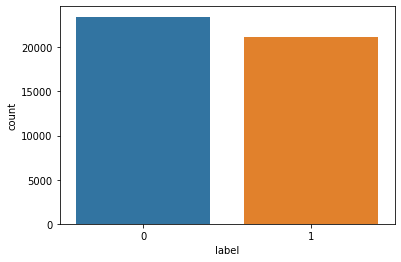

In [70]:
import seaborn as sns
sns.countplot('label',data=df)

### WORD CLOUD VISUALIZATION

In [65]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [66]:
#making worldcloud
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))
print(stop_words)

{"shan't", 'isn', 'down', 'for', 'the', 'own', 'were', "shouldn't", 'are', 'been', 'their', 'out', 't', 'don', 'so', 'himself', 'hers', 'this', 'other', "you'd", "wouldn't", 'm', 'your', 'any', 'our', 'aren', 'i', 'theirs', 'shouldn', 'under', 'how', 'each', 'by', 'what', 'will', 'my', 'into', 'ma', 'yourselves', "couldn't", 'he', 'had', 'it', 'if', 'between', 'while', 'hasn', 'ourselves', "haven't", "needn't", "you've", 'whom', 'having', 'll', 'no', 'them', 'few', 'ain', 'these', 'you', 'hadn', 'themselves', "hasn't", 'weren', 'him', 'who', "it's", 'too', "isn't", 'her', 'from', 'there', 'does', 'than', 'his', 'in', "mustn't", 'most', 'haven', 'y', 'mustn', 'that', "weren't", 'why', 'very', 'such', 'during', 's', 'myself', 've', 'yourself', 'have', 'a', 'once', "you're", 'or', 'off', 'just', 'up', 'has', 'to', "hadn't", 'over', 'some', 'against', 'further', 'is', 'couldn', 'through', 'until', 'before', 'then', 'being', "wasn't", 'same', 'we', "aren't", "she's", 'after', 'they', "might

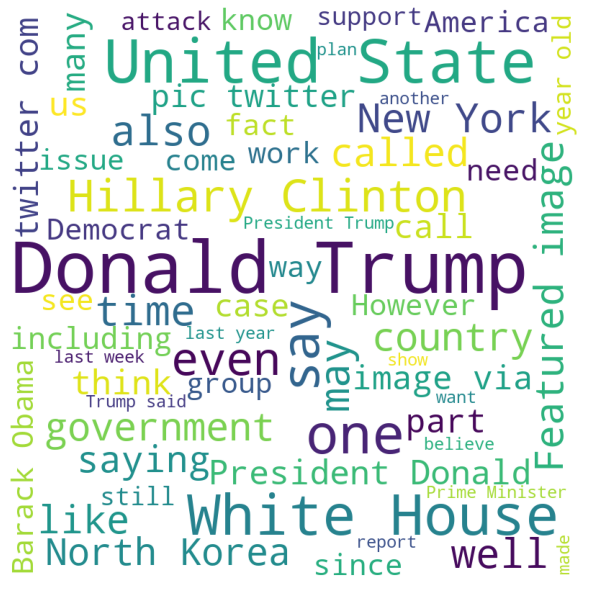

In [67]:
# visualizing the most frequent words using matplot library
comment_words = ' '
for words in df['text']: 
    comment_words = comment_words + words + ' '
    
wordcloud = WordCloud(width = 800, height = 800, 
                background_color='white' , 
                stopwords = stop_words, 
                min_font_size = 20).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)

## FEATURE EXTRACTION

### WORD EMBEDDING USING GLOVE (GLOBAL VECTORS FOR WORD REPRESENTATION)

In [40]:
# assigning parameters
SEQUENCE_LENGTH = 100 # the length of all sequences (number of words per sample)
EMBEDDING_SIZE = 100  # Using 100-Dimensional GloVe embedding vectors
TEST_SIZE = 0.25 # ratio of testing set

BATCH_SIZE = 64
EPOCHS = 20 # number of epochs

# to convert labels to integers and vice-versa
label2int = {"fake": 0, "true": 1}
int2label = {0: "fake", 1: "true"}

In [41]:
# load the data
X = df['text']
y = df['label']

In [42]:
# Text tokenization
# vectorizing text, turning each text into sequence of integers
tokenizer = Tokenizer()

In [43]:
tokenizer

In [44]:
tokenizer.fit_on_texts(X)
# convert to sequence of integers
X = tokenizer.texts_to_sequences(X)

In [45]:
# Let's try to print the fifth sample:
print(X[5])

[596, 1547, 1880, 25252, 214, 1819, 106, 13, 11, 6, 10693, 1, 375, 3, 833, 3, 1880, 34942, 5, 1166, 45, 3, 2299, 823, 2, 202, 66, 258, 98, 33, 23, 196, 236, 8, 648, 2, 22, 1603, 273, 5, 2132, 31, 1547, 418, 20, 1, 579, 3, 2355, 2612, 1603, 4, 5209, 1098, 3, 53, 757, 1465, 6, 4, 1492, 3747, 16, 4, 4753, 5, 8554, 444, 9, 538, 14, 648, 2, 22, 1603, 273, 5, 2132, 95, 26, 11, 3509, 14, 11, 1966, 219, 2612, 757, 17, 6, 125, 2698, 48, 58, 1775, 3, 11933, 3874, 6, 19, 1368, 34, 59, 41, 202, 1, 1098, 41, 40, 2729, 8, 146, 929, 362, 24, 1880, 28, 24, 1612, 2, 2118, 5, 25252, 135, 6, 42, 2698, 6, 1, 282, 41, 28, 39, 2, 202, 2677, 2612, 10331, 53, 696, 8, 1, 1880, 43, 42, 1184, 4084, 9, 106, 30, 47, 3843, 53, 757, 34, 32, 168, 33, 56, 166, 8, 62, 40, 22, 82, 769, 3, 9545, 19044, 2, 1649, 407, 1, 1330, 3, 3985, 3, 7906, 48, 1184, 2899, 2327, 3, 58, 17, 835, 4, 2761, 3843, 1670, 14, 83, 109, 22, 935, 18, 2030, 1310, 325, 1424, 230, 8, 26, 584, 237, 40, 243, 22, 1, 245, 272, 532, 22796, 150, 11, 58, 

A bunch of numbers, each integer correspond to a word in the vocabulary and  the samples doesn't have the same length, we need a way to have a fixed length sequence.

As a result, we're using keras.preprocessing.sequence.pad_sequences() function that pad sequences at the beginning of each sequence with zeros:

In [46]:
# convert to numpy arrays
X = np.array(X)
y = np.array(y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [47]:
X

array([list([70, 12, 4805, 55, 2712, 61, 80, 7, 4442, 636, 26, 11, 2778, 70, 12, 78, 1352, 38, 2450, 56, 213, 4, 1620, 61, 80, 5, 651, 14, 27, 8, 531, 13, 43, 2, 409, 4, 7653, 55, 2, 19, 3130, 8072, 5, 1, 151, 4704, 615, 97, 117, 1, 107, 945, 238, 977, 43, 78, 51, 451, 2, 90, 5, 13, 1352, 38, 90, 14, 18, 73, 108, 4638, 9313, 2861, 5, 10550, 32, 187, 2, 2450, 56, 3, 177, 954, 330, 3130, 8072, 5, 109, 1, 151, 4704, 615, 97, 117, 4, 1620, 5, 4155, 61, 80, 36, 1552, 5937, 1018, 40, 22, 4, 355, 80, 10, 142, 18, 73, 108, 4638, 9313, 2861, 5, 10550, 32, 187, 2, 2450, 56, 3, 177, 954, 330, 3130, 8072, 5, 109, 1, 151, 4704, 615, 97, 117, 4, 1620, 5, 4155, 61, 80, 40, 22, 4, 355, 80, 10, 142, 70, 743, 12, 628, 12, 7, 761, 399, 157, 39, 18, 72576, 18, 41, 363, 1228, 58, 769, 3, 36, 4805, 4, 61, 80, 7, 15359, 88, 26, 6834, 5966, 29979, 26077, 104, 12, 19, 1330, 3, 7399, 305, 38, 109, 634, 76, 2, 1363, 1476, 1, 13570, 227, 477, 2, 2450, 1, 120, 575, 4, 1620, 61, 80, 6694, 55599, 20504, 628, 66, 51,

In [48]:
# pad sequences at the beginning of each sequence with 0's
# for example if SEQUENCE_LENGTH=4:
# [[5, 3, 2], [5, 1, 2, 3], [3, 4]]
# will be transformed to:
# [[0, 5, 3, 2], [5, 1, 2, 3], [0, 0, 3, 4]]
X = pad_sequences(X, maxlen=SEQUENCE_LENGTH)

In [49]:
X

array([[   102,    227,    114, ...,  10551,    559,    505],
       [    15,      8,    435, ...,   5518,    559,    505],
       [   144,    277,  72597, ...,   7624,    559,    505],
       ...,
       [    57,   1709, 103523, ...,    157,     13,     15],
       [  6666,   2566,   1922, ...,    689,     16,   9162],
       [   220,     11,    469, ...,   5709,    337,    476]], dtype=int32)

we set SEQUENCE_LENGTH = 100. In this way, all sequences have a length of 100.

Now our labels are text also, but we are going to make a different approach here, since the labels are only "true" and "fake", we need to one-hot encode them:

In [50]:
# One Hot encoding labels
# [1, 0, 1, 0, 1] convert to:
# [[0, 1], [1, 0], [0, 1], [1, 0], [0, 1]]
y = to_categorical(y)

In [51]:
# We used keras.utils.to_categorial() here. Let's try to print the first sample of the labels:
print(y[0])

[1. 0.]


### TRAIN TEST SPLIT

In [52]:
# Next, let's shuffle and split training and testing data:
# split and shuffle
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=7)

### MODEL BUILDING

The first layer is a pre-trained embedding layer that maps each word to a N-dimensional vector of real numbers ( the EMBEDDING_SIZE corresponds to the size of this vector, in this case 100). Two words that have similar meaning tend to have very close vectors.

The second layer is a recurrent neural network with LSTM units. 

Finally, the output layer is 2 neurons each corresponds to "true" or "fake" with a softmax activation function.

In [53]:
# Let's start by writing a function to load the pre-trained embedding vectors:
def get_embedding_vectors(tokenizer, dim=100):
    embedding_index = {}
    with open(f"/content/glove.6B.{dim}d.txt", encoding='utf8') as f:
        for line in tqdm.tqdm(f, "Reading GloVe"):
            values = line.split()
            word = values[0]
            vectors = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = vectors

    word_index = tokenizer.word_index
    embedding_matrix = np.zeros((len(word_index)+1, dim))
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            # words not found will be 0s
            embedding_matrix[i] = embedding_vector
            
    return embedding_matrix

In [54]:
def get_model(tokenizer, lstm_units):
    """
    Constructs the model,
    Embedding vectors => LSTM => 2 output Fully-Connected neurons with softmax activation
    """
    # get the GloVe embedding vectors
    embedding_matrix = get_embedding_vectors(tokenizer)
    model = Sequential()
    model.add(Embedding(len(tokenizer.word_index)+1,
              EMBEDDING_SIZE,
              weights=[embedding_matrix],
              trainable=False,
              input_length=SEQUENCE_LENGTH))

    model.add(LSTM(lstm_units, recurrent_dropout=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(2, activation="softmax"))
    # compile as rmsprop optimizer
    # aswell as with recall metric
    model.compile(optimizer="rmsprop", loss="categorical_crossentropy",
                  metrics=["accuracy", keras_metrics.precision(), keras_metrics.recall()])
    model.summary()
    return model

In [55]:
# constructs the model with 128 LSTM units
model = get_model(tokenizer=tokenizer, lstm_units=128)

Reading GloVe: 400000it [00:12, 31928.78it/s]


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          10353100  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 258       
Total params: 10,470,606
Trainable params: 117,506
Non-trainable params: 10,353,100
_________________________________________________________________


In [62]:
# print our data shapes
print("X_train.shape:", X_train.shape)
print("X_test.shape:", X_test.shape)
print("y_train.shape:", y_train.shape)
print("y_test.shape:", y_test.shape)

X_train.shape: (33516, 100)
X_test.shape: (11173, 100)
y_train.shape: (33516, 2)
y_test.shape: (11173, 2)


In [63]:
# initialize our ModelCheckpoint and TensorBoard callbacks
# model checkpoint for saving best weights
#model_checkpoint = ModelCheckpoint("results/fakenews classifier_{val_loss:.2f}", save_best_only=True, verbose=1)
# for better visualization
#tensorboard = TensorBoard(f"logs/fakenews classifier_{time.time()}")

# train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test),
          batch_size=BATCH_SIZE, epochs=5,
          verbose=1)

Epoch 1/5
524/524 [==============================] - 229s 438ms/step - loss: 0.1036 - accuracy: 0.9621 - precision: 0.9461 - recall: 0.9397 - val_loss: 0.0917 - val_accuracy: 0.9689 - val_precision: 0.9521 - val_recall: 0.9434
Epoch 2/5
524/524 [==============================] - 228s 434ms/step - loss: 0.0824 - accuracy: 0.9703 - precision: 0.9566 - recall: 0.9466 - val_loss: 0.0807 - val_accuracy: 0.9722 - val_precision: 0.9602 - val_recall: 0.9493
Epoch 3/5
524/524 [==============================] - 225s 429ms/step - loss: 0.0692 - accuracy: 0.9751 - precision: 0.9630 - recall: 0.9517 - val_loss: 0.0762 - val_accuracy: 0.9746 - val_precision: 0.9652 - val_recall: 0.9538
Epoch 4/5
524/524 [==============================] - 229s 437ms/step - loss: 0.0581 - accuracy: 0.9797 - precision: 0.9671 - recall: 0.9558 - val_loss: 0.0750 - val_accuracy: 0.9768 - val_precision: 0.9686 - val_recall: 0.9577
Epoch 5/5
524/524 [==============================] - 225s 429ms/step - loss: 0.0485 - accura

### MODEL ACCURACY

In [64]:
# get the loss and metrics
result = model.evaluate(X_test, y_test)
# extract those
loss = result[0]
accuracy = result[1]
precision = result[2]
recall = result[3]

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision:   {precision*100:.2f}%")
print(f"Recall:   {recall*100:.2f}%")

350/350 [==============================] - 14s 41ms/step - loss: 0.0703 - accuracy: 0.9763 - precision: 0.9711 - recall: 0.9620
Accuracy: 97.63%
Precision:   97.11%
Recall:   96.20%


### MODEL EVALUATION

In [58]:
def get_predictions(text):
    sequence = tokenizer.texts_to_sequences([text])
    # pad the sequence
    sequence = pad_sequences(sequence, maxlen=SEQUENCE_LENGTH)
    # get the prediction
    prediction = model.predict(sequence)[0]
    # one-hot encoded vector, revert using np.argmax
    return int2label[np.argmax(prediction)]

In [59]:
text = "Fifty prominent Republican national security officials, including a former CIA director, on Monday called party nominee Donald Trump unqualified to lead the country and said he would be â€œthe most reckless president in American history.â€ The statement was the latest repudiation of Trumpâ€™s candidacy by veteran Republican national security specialists, and was remarkable for the harshness of its language. â€œMr. Trump lacks the character, values, and experience to be president. He weakens U.S. moral authority as the leader of the free world. He appears to lack basic knowledge about and belief in the U.S. Constitution, U.S. laws and U.S. institutions, including religious tolerance, freedom of the press, and an independent judiciary,â€ the statement said. â€œNone of us will vote for Donald Trump,â€ said the statement"
print(get_predictions(text))

true
